false positive rate: 0.01
true positive rate 0.01
nubmer of patient samples 4900


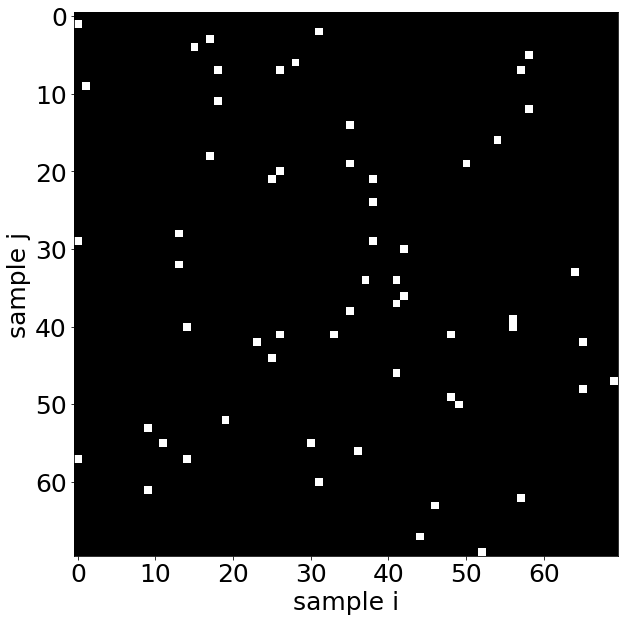

In [354]:
import numpy as np
import random
import matplotlib.pyplot as plt
import uuid
from itertools import combinations
### initialize test pool ###

plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25) 
plt.rcParams.update({'font.size': 25})


true_positive_rate = 0.1

global false_negative_rate
global false_positive_rate


false_positive_rate = 0.01
true_positive_rate = 0.01
patient_samples = int(np.sqrt(5000))**2



grand_test_pool = np.zeros((patient_samples))
ids_grand_pool = np.zeros((patient_samples),uuid.UUID)
pool_dictionary = {}


true_positives = 0
positive_patients= []
# positive_patients = random.choices(range(0,patient_samples),k=int(true_positive_rate*patient_samples))
for i in range(0,patient_samples):
    ID = uuid.uuid4()
    ids_grand_pool[i] = ID
    if random.random() <= true_positive_rate:
        true_positives += 1
        grand_test_pool[i] = 1
        pool_dictionary[ID] =1
        positive_patients.append(i)
    else:
        pool_dictionary[ID] =0

plt.figure(figsize=(10,10))
plt.xlabel("sample i")
plt.ylabel("sample j")
plt.imshow(np.reshape(grand_test_pool,[int(np.sqrt(len(grand_test_pool))),int(np.sqrt(len(grand_test_pool)))]),cmap="Greys_r")
true_negatives = patient_samples - true_positives

print("false positive rate:", false_positive_rate)
print("true positive rate",true_positive_rate)
print("nubmer of patient samples",patient_samples)

In [355]:
pool_dictionary

{UUID('022d9bd6-9827-4841-8d49-53a57ba5f9b9'): 0,
 UUID('a6c32741-e9a9-4ee5-add1-7d70702ce746'): 0,
 UUID('ee71194f-2a33-4b06-aa19-5f3b9224a187'): 0,
 UUID('e85b07dc-910f-4834-9935-208f2fb70de8'): 0,
 UUID('2f233462-207f-4b94-8bd7-3210793a0fd1'): 0,
 UUID('fe300be8-2a41-4520-9544-27b4eb4c5574'): 0,
 UUID('21c4af33-bdd2-4b93-9c92-fea30b00b102'): 0,
 UUID('6b596812-268d-4775-a107-e84e755a2b48'): 0,
 UUID('64523bb8-63a4-4702-9e55-07f3c7e985df'): 0,
 UUID('f619bd26-2bef-490a-a25d-91f0b6fac62b'): 0,
 UUID('42794648-cecd-43e2-ba67-95b161d981d8'): 0,
 UUID('4961fa8e-86d9-4228-976f-5e3ca6fde886'): 0,
 UUID('9b3f43e0-eae4-4185-bf36-50f6e61f0804'): 0,
 UUID('150a8830-6d37-48b7-998c-1794b2fd34e9'): 0,
 UUID('8413a4b6-88af-4d4e-a374-5290a44ee570'): 0,
 UUID('7de2abfc-c3b9-41c5-875c-787f3e25b7dc'): 0,
 UUID('ed2c29d4-740e-4b33-8482-d4edf7c48dc3'): 0,
 UUID('ec87f9bd-4667-4718-ac9a-6a15bfe97ff1'): 0,
 UUID('6d9255e5-2d03-4177-ab6f-e4415159636b'): 0,
 UUID('8cb3ef12-1656-48b9-bf9a-c5144f0f0a1d'): 0,


# proposed penalty for dilution
false negative probability of a single, undiluted sample : $p_-$

corrected false negative after dilution: 

# $p_-^{diluted} = p_- (1 + \frac{m_{pools}}{n_{samples}})^h $

where $h$ is a scaling constant that depends on qPCR sensitivity

In [442]:
import math
#guess an appropriate pool size - this should later be optimized      
#pool_size = int(np.sqrt(patient_samples))

#the nubmer of pools is the number of tests - 
#let's try to make some gains and see how good the accuracy still is
max_pools = 384
min_pool_size = patient_samples/max_pools
print("minimum pool size for non-overlapping but complete sample coverage", min_pool_size)
pool_size = math.ceil(min_pool_size)*5
print("target size: ", pool_size)
for i in range(0, 100):
    if patient_samples%(pool_size+i) == 0:
        pool_size = pool_size+i
        print("final pool size considering even division of chapters ", pool_size)
        break

       
        
 

number_of_pools = 0

#initialize pools 
pools = []
for i in range(0, len(ids_grand_pool), pool_size):
    pools.append(list(ids_grand_pool[i:i+pool_size]))
print("first chapter of pools: ",len(pools))        
# combinatorial pool choice - try to maximize diversity
number_of_pools += len(pools)
chapter_size = len(pools)
chapter = 0
while number_of_pools < max_pools:
    for page in range(0,chapter_size):
        if number_of_pools >= max_pools: 
            break
        next_pool = []
        for item in range(0,pool_size):
            next_pool.append(pools[chapter_size*chapter+(page+item)%chapter_size][item])
        pools.append(next_pool)
        number_of_pools += 1
        
    chapter += 1

base_false_negative_rate = 0.1
false_negative_rate = base_false_negative_rate*(1 + number_of_pools/patient_samples)**2.4


print("number of pools: ", len(pools))    
print("pool size:", pool_size)
print("dilution-dependent false negative rate", false_negative_rate)

minimum pool size for non-overlapping but complete sample coverage 12.760416666666666
target size:  65
final pool size considering even division of chapters  70
first chapter of pools:  70
number of pools:  384
pool size: 70
dilution-dependent false negative rate 0.11985058256974526


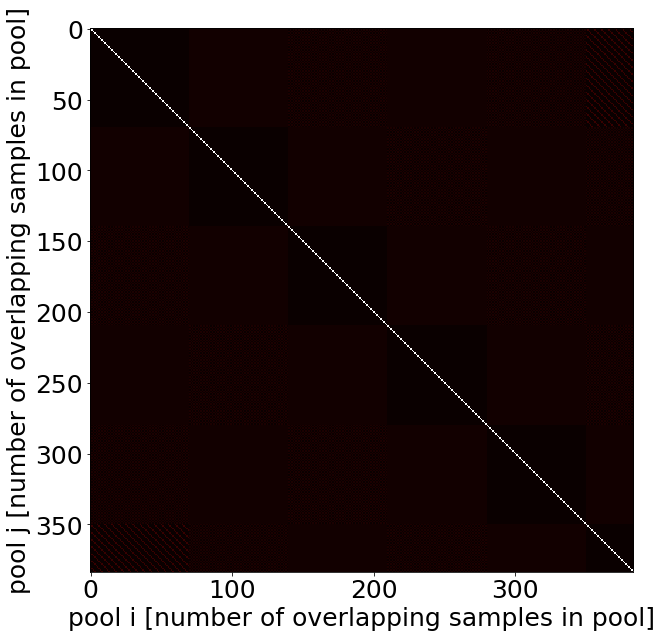

In [443]:
#check the extent of overlap between our pools
check_intersections = np.zeros((max_pools,max_pools))
for i in range(0, max_pools):
    for j in range(0, max_pools):
        check_intersections[i,j] = len(list(set(pools[i]) & set(pools[j])))
        
plt.figure(figsize=(10,10))        
plt.imshow(check_intersections,cmap="hot")  
plt.xlabel("pool i [number of overlapping samples in pool]")
plt.ylabel("pool j [number of overlapping samples in pool]")
plt.show()
plt.close()

In [444]:
def run_test(samples, pool_dictionary):
    pool_result = 0
    false_positive = 0
    false_negative = 0
    for ID in samples:
        if pool_dictionary[ID] == 1:
            if random.random() < false_negative_rate:
                false_negative = 1
            else:
                pool_result = 1
        else:
            if random.random() < false_positive_rate:
                pool_result = 1 
                false_positive = 1
        if pool_result == 1 and false_negative == 1:
            false_negative = 0 #silent false negative since some other sample tested positive in the pool
    return pool_result, false_negative, false_positive


# conduct the tests now on each pool - sort them into negative and positive groups
positive_pools = []
negative_pools = []
for pool in pools:
    if run_test(pool, pool_dictionary)[0] == 1:
        positive_pools.append(list(pool))
    else:
        negative_pools.append(list(pool))        
        
flat_pos_pools = [val for sublist in positive_pools for val in sublist]
flat_neg_pools = [val for sublist in negative_pools for val in sublist]

false pos/ neg sample 0.2371410865523652
false neg/pos sample 0.05084745762711865
fold efficiency:  12.760416666666666 samples/test
coverage (redundancy):  pools*size / samples:  5.485714285714286 x
correctly identified rate 0.7651020408163265 correct results/sample


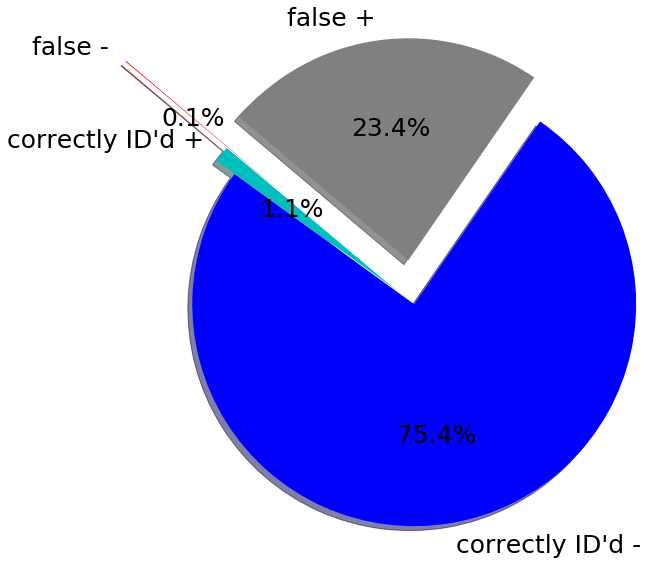

In [445]:
# assess the accuracy by comparing with the dictionary of true positives
errors = 0
correctly_identified = 0
correctly_identidied_positives = 0
correctly_identidied_negatives = 0
false_pos_errors = 0
false_neg_errors = 0
final_positives = list(set(flat_pos_pools) - set(flat_neg_pools))
for i in set(final_positives):
    if pool_dictionary[i] != 1:
        errors += 1
        false_pos_errors += 1
    else :
        correctly_identified += 1
        correctly_identidied_positives += 1
for i in set(flat_neg_pools):
    if pool_dictionary[i] != 0:
        errors += 1
        false_neg_errors += 1
    else :
        correctly_identified += 1  
        correctly_identidied_negatives += 1
#print("errors/sample", errors/patient_samples)        
print("false pos/ neg sample", false_pos_errors/true_negatives)        
print("false neg/pos sample", false_neg_errors/true_positives)  
print("fold efficiency: ", patient_samples/number_of_pools,"samples/test")
print("coverage (redundancy):  pools*size / samples: ", (number_of_pools*pool_size)/patient_samples, "x")
print("correctly identified rate", correctly_identified/patient_samples, "correct results/sample")


sizes = [correctly_identidied_positives, correctly_identidied_negatives, false_pos_errors, false_neg_errors]
# print(np.sum(sizes))
labels = ["correctly ID'd +","correctly ID'd -","false +","false -"]
explode = (0.1, 0 , .2,.7)
plt.figure(figsize=(10,10))        
plt.pie(sizes, labels=labels, explode = explode,colors=["c","b","grey","r"],
autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()
plt.close()



# sizes = [correctly_identidied_positives, false_pos_errors]
# # print(np.sum(sizes))
# labels = ["correctly identified positives","false +"]
# explode = (0.1, 0)
# plt.figure(figsize=(10,10))        
# plt.pie(sizes, labels=labels, explode = explode,colors=["b","grey"],
# autopct='%1.1f%%', shadow=True, startangle=140)
# plt.axis('equal')
# plt.show()
# plt.close()

# sizes = [correctly_identidied_negatives, false_neg_errors]
# # print(np.sum(sizes))
# labels = ["correctly identified negatives","false -"]
# explode = (0.1, 0)
# plt.figure(figsize=(10,10))        
# plt.pie(sizes, labels=labels, explode = explode,colors=["b","r"],
# autopct='%1.1f%%', shadow=True, startangle=140)
# plt.axis('equal')
# plt.show()
# plt.close()

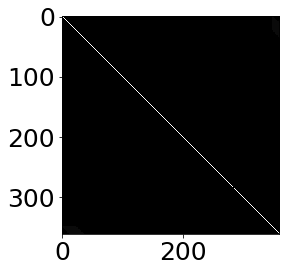

In [247]:
# show intersection between positive pools
max_pos_pools = len(positive_pools)
intersect_final = []
check_pos_intersections = np.zeros((max_pos_pools,max_pos_pools))
for i in range(0, max_pos_pools):
    for j in range(0, max_pos_pools):
        current_intersect = list(set(positive_pools[i]) & set(positive_pools[j]))
        check_pos_intersections[i,j] = len(current_intersect)
                
plt.imshow(check_pos_intersections,cmap="Greys_r")   
plt.show()
plt.close()